<a href="https://colab.research.google.com/github/polesh21/iowa_liquor_sales/blob/stage/EDA_iowa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
#ensure the file is accessible
!ls /content/gdrive/'My Drive'/'Colab Notebooks'/temp

DPolieshko-0cf48e53ce74.json


In [0]:
from google.cloud import bigquery
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/gdrive/My Drive/Colab Notebooks/temp/DPolieshko-0cf48e53ce74.json"

In [5]:
#ensure the path is set correctly
!echo $GOOGLE_APPLICATION_CREDENTIALS

/content/gdrive/My Drive/Colab Notebooks/temp/DPolieshko-0cf48e53ce74.json


In [0]:
client = bigquery.Client()

In [0]:
sql = '''
        SELECT *
        FROM `bigquery-public-data.iowa_liquor_sales.sales`
         where date >='2017-01-01' and date <='2019-12-31'
        '''

df = client.query(sql).to_dataframe()

In [8]:
df[['store_name','county','category_name','vendor_name','item_description','category_name']].describe()
 #   'bottle_volume_ml','state_bottle_cost','state_bottle_retail','bottles_sold','sale_dollars','volume_sold_liters']].describe()

,store_name,county,category_name,vendor_name,item_description,category_name
count,7027179,6977246,7019110,7027176,7027179,7019110
unique,2007,132,55,250,5303,55
top,Hy-Vee #3 / BDI / Des Moines,POLK,American Vodkas,DIAGEO AMERICAS,Black Velvet,American Vodkas
freq,63906,1160867,1063138,1193449,182819,1063138


In [0]:
df = df.dropna()
df = df.drop_duplicates()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6315669 entries, 0 to 7027178
Data columns (total 24 columns):
invoice_and_item_number    object
date                       object
store_number               object
store_name                 object
address                    object
city                       object
zip_code                   object
store_location             object
county_number              object
county                     object
category                   object
category_name              object
vendor_number              object
vendor_name                object
item_number                object
item_description           object
pack                       int64
bottle_volume_ml           int64
state_bottle_cost          float64
state_bottle_retail        float64
bottles_sold               int64
sale_dollars               float64
volume_sold_liters         float64
volume_sold_gallons        float64
dtypes: float64(5), int64(3), object(16)
memory usage: 1.2+ GB


In [0]:
df[['store_name','county','category_name','vendor_name','item_description','category_name']].describe()
 #   'bottle_volume_ml','state_bottle_cost','state_bottle_retail','bottles_sold','sale_dollars','volume_sold_liters']].describe()

,store_name,county,category_name,vendor_name,item_description,category_name
count,6315669,6315669,6315669,6315669,6315669,6315669
unique,1863,129,55,243,5090,55
top,Hy-Vee #3 / BDI / Des Moines,POLK,American Vodkas,DIAGEO AMERICAS,Black Velvet,American Vodkas
freq,63770,1032853,958487,1072822,166209,958487


In [89]:
df['date']= pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_week_num'] = df['date'].dt.dayofweek
df['day_of_week'] = df['date'].dt.weekday_name
df

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,month,year,year_month,day_of_week,day_of_week_num
0,INV-09442400016,2017-12-26,3644,Wal-Mart 2764 / Altoona,3501 8th St SW,Altoona,50009,POINT (-93.505276 41.644195),77,POLK,1012100,Canadian Whiskies,085,Brown Forman Corp.,12476,Canadian Mist Whiskey Pet,12,750,5.44,8.16,12,97.92,9.00,2.38,12,2017,2017-12,Tuesday,1
1,INV-06538200042,2017-08-08,2619,Hy-Vee Wine and Spirits / WDM,1725 74th St,West Des Moines,50266,POINT (-93.808855 41.598515),77,POLK,1012100,Canadian Whiskies,115,CONSTELLATION BRANDS INC,11774,Black Velvet,24,375,3.07,4.61,24,110.64,9.00,2.38,8,2017,2017-8,Tuesday,1
2,INV-07051500008,2017-09-05,3980,Wal-Mart 1721 / Iowa City,919 Hwy 1 West,Iowa City,52246,POINT (-91.552125 41.646646),52,JOHNSON,1012100,Canadian Whiskies,395,PROXIMO,14192,Pendleton Canadian Whisky,12,750,13.10,19.65,12,235.80,9.00,2.38,9,2017,2017-9,Tuesday,1
3,INV-12074500001,2018-05-15,4923,Casey's General Store #2270 / Aurelia,"100, Pearl St",Aurelia,51005,POINT (-95.437639 42.712097),18,CHEROKEE,1012100,Canadian Whiskies,115,CONSTELLATION BRANDS INC,11774,Black Velvet,24,375,3.07,4.61,24,110.64,9.00,2.38,5,2018,2018-5,Tuesday,1
6,INV-02603800013,2017-01-09,4619,Smokin' Joe's #3 Tobacco and Liquor Outlet,1737 Ave H,Fort Madison,52627,POINT (-91.32982400000002 40.63021),56,LEE,1012100,Canadian Whiskies,115,CONSTELLATION BRANDS INC,11774,Black Velvet,24,375,3.07,4.61,24,110.64,9.00,2.38,1,2017,2017-1,Monday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027174,INV-16583300042,2018-12-27,3592,Wal-Mart 0886 / Fort Dodge,3036 1st Ave South,Fort Dodge,50501,POINT (-94.153456 42.505334),42,Hardin,1031100,American Vodkas,370,PERNOD RICARD USA,38031,Smithworks,12,750,7.49,11.24,12,134.88,9.00,2.37,12,2018,2018-12,Thursday,3
7027175,INV-14400600038,2018-09-12,3776,Wal-Mart 5115 / Davenport,3101 West Kimberly Rd,Davenport,52806,POINT (-90.620069 41.559268),82,SCOTT,1031100,American Vodkas,370,PERNOD RICARD USA,38031,Smithworks,12,750,7.49,11.24,12,134.88,9.00,2.37,9,2018,2018-9,Wednesday,2
7027176,INV-18240000050,2019-03-20,3592,Wal-Mart 0886 / Fort Dodge,3036 1st Ave South,Fort Dodge,50501,POINT (-94.153456 42.505334),42,Hardin,1031100,American Vodkas,370,PERNOD RICARD USA,38031,Smithworks,12,750,7.49,11.24,12,134.88,9.00,2.37,3,2019,2019-3,Wednesday,2
7027177,INV-23820900021,2019-12-10,5380,Transit General Store,2324 Transit Plaza,Sioux City,51106,POINT (-96.378682 42.476368),97,WOODBURY,1031100,American Vodkas,370,PERNOD RICARD USA,38031,Smithworks,12,750,7.49,11.24,2,22.48,1.50,0.39,12,2019,2019-12,Tuesday,1


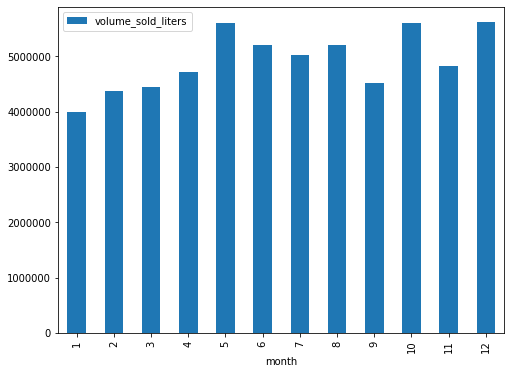

In [97]:
by_month = df.groupby(['month']).sum().reset_index()
liters_by_month = by_month[['month','volume_sold_liters']]

import matplotlib.pyplot as plt

liters_by_month.plot(kind='bar',x='month',y='volume_sold_liters')

plt.show()

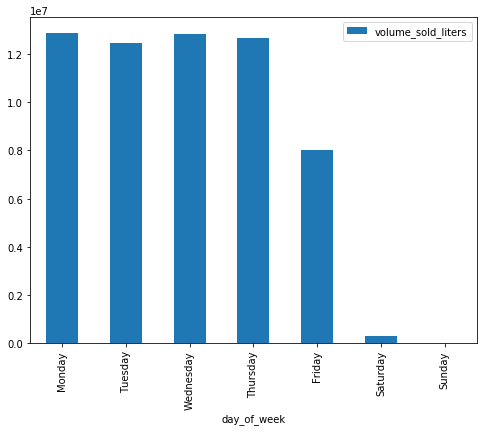

In [95]:
by_day = df.groupby(['day_of_week_num','day_of_week']).sum().reset_index()
liters_by_day = by_day[['day_of_week_num','day_of_week','volume_sold_liters']]

liters_by_day.plot(kind='bar',x='day_of_week',y='volume_sold_liters')

plt.rcParams["figure.figsize"] = (8,6)

plt.show()

In [0]:
# by_date = df.groupby(['date']).sum().reset_index()
# by_date = by_date[['date','sale_dollars','volume_sold_liters']].sort_values(by='date')
# by_date['week_start'] = by_date['date'].dt.to_period('W').apply(lambda r: r.start_time)
# by_date['day_of_week'] = by_date['date'].dt.dayofweek +1
# by_date

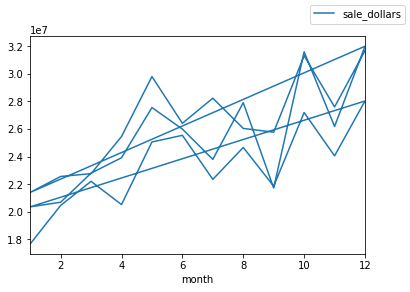

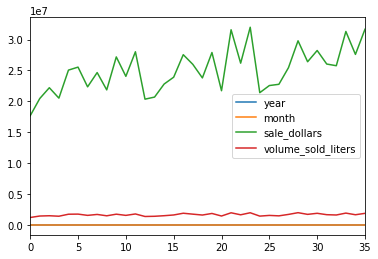

In [24]:
from matplotlib import pyplot
ax = by_month_short.plot(x="month", y="sale_dollars", legend=False)
ax.figure.legend()
by_month_short.plot()

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# Create some mock data
# t = np.arange(0.01, 10.0, 0.01)
# data1 = np.exp(t)
# data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('sale_dollars', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [0]:
by_date = df.groupby(['date']).sum().reset_index()
by_date = by_date[['date','sale_dollars','volume_sold_liters']].sort_values(by='date')

#by_date['week_start'] = by_date['date'].dt.to_period('W').apply(lambda r: r.start_time)
by_date

,date,sale_dollars,volume_sold_liters
0,2019-12-02,1227092.23,73620.88
1,2019-12-03,1687577.07,98176.06
2,2019-12-04,1575625.04,93691.67
3,2019-12-05,1432555.03,79316.29
4,2019-12-06,1560474.12,98185.59
5,2019-12-09,1581530.33,95999.07
6,2019-12-10,1680746.95,103074.72
7,2019-12-11,1622221.53,94452.70
8,2019-12-12,1243708.82,71425.35
9,2019-12-13,1514251.65,96765.26


In [0]:
print(df['category_name'].value_counts().head(5))

Temporary & Specialty Packages    1688
Imported Dry Gins                 1458
Single Malt Scotch                 909
Gold Rum                           859
Straight Rye Whiskies              774
Name: category_name, dtype: int64


In [0]:
df['city'].value_counts().head(5)

Des Moines      849
Cedar Rapids    624
Davenport       321
Cedar Falls     297
Sioux City      296
Name: city, dtype: int64


In [0]:
for city in top_5_cities.index:
    print(city + '\t: ' + str(round(df.loc[df['city'] == city, 'volume_sold_liters'].sum())))

In [0]:
df

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,INV-23082500005,2019-11-07,3670,Wal-Mart 2827 / Coralville,2801 Commerce Dr,Coralville,52241,POINT (-91.610774 41.695806),52,JOHNSON,1701100,Temporary & Specialty Packages,065,Jim Beam Brands,100636,Jim Beam Mini 12 Seasons,6,600,6.50,9.75,72,702.00,43.20,11.41
1,INV-20971900006,2019-07-31,2653,Hy-Vee Wine and Spirits / Washington,1004 W Madison St,Washington,52353,POINT (-91.704567 41.296576),92,WASHINGTON,1701100,Temporary & Specialty Packages,370,PERNOD RICARD USA,15727,Jameson Caskmates Stout Mini,10,50,7.92,11.88,1,11.88,0.05,0.01
2,INV-23762600005,2019-12-09,5476,Eldridge Mart,209 E LeClaire Rd,Eldridge,52748,POINT (-90.58154 41.654676),82,SCOTT,1701100,Temporary & Specialty Packages,434,LUXCO INC,100503,St Brendans w/3-50mls,6,900,7.69,11.54,6,69.24,5.40,1.42
3,INV-23402500006,2019-11-22,4023,Wal-Mart 1389 / Boone,1515 SE Marshall St,Boone,50036,POINT (-93.869892 42.035093),8,BOONE,1701100,Temporary & Specialty Packages,260,DIAGEO AMERICAS,43777,Captain Morgan Gingerbread Spiced Rum,12,750,9.06,13.59,24,326.16,18.00,4.75
4,INV-16717000001,2019-01-03,4070,Grieder Beverage Depot,708 13th St,Belle Plaine,52208,POINT (-92.278 41.897054),6,BENTON,1901200,Special Order Items,370,PERNOD RICARD USA,902780,SOOH Hiram Walker Cherry Brandy,12,1000,6.50,9.75,60,585.00,60.00,15.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,INV-20527500025,2019-07-10,5776,Casey's General Store #2890 / West Liberty,402 W 15th St,West Liberty,52776,POINT (-91.266302 41.583271),70,MUSCATINE,1042100,Imported Dry Gins,260,DIAGEO AMERICAS,28865,Tanqueray Gin,24,375,6.99,10.49,6,62.94,2.25,0.59
9996,INV-21226700026,2019-08-14,5750,Casey's General Store #2920 / Ankeny,1010 SE National Dr,Ankeny,50021,POINT (-93.582014 41.70486400000001),77,POLK,1042100,Imported Dry Gins,260,DIAGEO AMERICAS,28865,Tanqueray Gin,24,375,6.99,10.49,6,62.94,2.25,0.59
9997,INV-17430000059,2019-02-08,5697,Casey's #3770 - Glenwood,601 S Locust Street,Glenwood,51534,POINT (-95.744501 41.040507),65,MILLS,1042100,Imported Dry Gins,260,DIAGEO AMERICAS,28865,Tanqueray Gin,24,375,6.99,10.49,6,62.94,2.25,0.59
9998,INV-22645400021,2019-10-18,5864,Casey's General Store #2803 / Villisca,309 N U Ave,Villisca,50864,POINT (-94.985437 40.934673),69,MONTGOMERY,1042100,Imported Dry Gins,260,DIAGEO AMERICAS,28865,Tanqueray Gin,24,375,6.99,10.49,6,62.94,2.25,0.59
